In [180]:
!pip3 install matplotlib

In [181]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import collections
from enum import Enum
from typing import List, Optional
from dataclasses import dataclass, field

origData = []
MIN_FILTER_SIZE = 3
FILTER_SIZE = 33
FIG_SIZE = (42, 13)
FRAME_SIZE = 180
FRAME_LEN = 160
DBL_EPSILON = sys.float_info.epsilon
DBL_MAX = sys.float_info.max

In [182]:
wfOrig = wave.open("raw_voice.wav", 'r')
origCh = wfOrig.getnchannels()
origSmpl = wfOrig.getsampwidth()
origRate = wfOrig.getframerate()
origNFrames = wfOrig.getnframes()
origData = wfOrig.readframes(origNFrames)
wfOrig.close()
print(f"Orig\n channels: {origCh}\n samples width: {origSmpl}\n frame rate: {origRate}\n frames: {origNFrames}\n data len: {len(origData)}")

Orig
 channels: 1
 samples width: 2
 frame rate: 8000
 frames: 1073741824
 data len: 485120


In [183]:
# def update_max(maxVal, val):
#     if (val> maxVal):
#         maxVal = val

# def update_value(newVal: float, oldVal: float, val: float) -> float:
#     return (val * newVal) + ((1.0 - val) * oldVal)

# # def setup_compress_thresh(threshold: float) -> float:
# #     if ((threshold > DBL_EPSILON) and (threshold < (1.0 - DBL_EPSILON))):
# #         current_threshold = threshold
# #         step_size = 1.0
# #         while (step_size > DBL_EPSILON):
# #             while (round()
        

# def frame_size(val1: int, val2: int) -> int:
#     frameSize = int(round(float(val1) * (float(val2) / 1000.0)))
#     return frameSize + (frameSize % 2)

# def bound(threshold: float, val: float) -> float:
#     return math.erf((math.sqrt(math.pi) / 2.0) * (val / threshold)) * threshold

# def fade(prevVal: float, nextVal: float, pos: int, fadeFactors) -> float:
#     return (fadeFactors[0][pos] * prevVal) + (fadeFactors[1][pos] * nextVal)

# def limit(minVal, val, maxVal):
#     return min(maxVal, max(minVal, val))

In [184]:
class GaussianFilter:
    m_sigma = float()
    m_weights = list()
    m_filterSize = int()
    
    def __init__(self, filterSize: int):
        self.m_filterSize = filterSize
        self.m_sigma = (((float(self.m_filterSize) / 2.0) - 1.0) / 3.0) + (1.0 / 3.0)
        self.m_weights = np.zeros(filterSize)
        totalWeight = 0.0
        offset = int(self.m_filterSize / 2)
        c1 = 1.0 / (self.m_sigma * np.sqrt(2.0 * np.pi))
        c2 = 2.0 * np.pow(self.m_sigma, 2.0)
    
        for i in range(0, self.m_filterSize):
            x = i - offset
            # self.m_weights[i] = c1 * np.exp(np.pow(x, 2.0) * -1)
            self.m_weights[i] = c1 * math.exp(-x * x / c2)
            totalWeight += self.m_weights[i]
    
        adjust = 1.0 / totalWeight
        for i in range(0, self.m_filterSize):
            self.m_weights[i] *= adjust
    
        print(f"GaussFilter: filter size = {self.m_filterSize}, sigma = {self.m_sigma}")

    def apply(self, data) -> float:
        result = 0.0
        tsum = 0.0

        # for i in range(0, data.cqueue_size()):
            
        
        if (data.size() != self.m_filterSize):
            print("Input data wrong size")
            return result

        itr = 0
        for val in data:
            result += val * self.m_weights[itr]
            itr += 1
        
        return result


In [185]:
# NOTE: frame->nb_samples == s->sample_advance == s->frame_len == self.m_frameLen
# NOTE: frame->extended_data[c] - сами данные
class AGC:
    m_is_first_frame = True
    def __init__(self, channels: int, filterSize: int, sampleRate: int, frameLenMsec: int):
        self.m_channels = channels
        self.m_filterSize = filterSize
        # self.m_sampleRate = sampleRate
        # self.m_frameLenMsec = frameLenMsec
        self.m_frameLen = self.frame_size(sampleRate, frameLenMsec)
        self.m_overlap = 0
        self.m_sampleAdvance = max(1, int(round(self.m_frameLen * (1.0 - self.m_overlap))))
        # self.m_prev_amplification_factor = np.ones(self.m_channels, dtype=np.array)
        self.m_prev_amplification_factor = np.ones(self.m_channels, dtype=np.int16)
        self.m_dc_correction_value = np.ones(self.m_channels, dtype=np.float64)
        self.m_gain_history_original = np.zeros((self.m_channels, self.m_filterSize), dtype=np.int16)
        self.m_gain_history_minimum = np.zeros((self.m_channels, self.m_filterSize), dtype=np.int16)
        self.m_gain_history_smoothed = np.zeros((self.m_channels, self.m_filterSize), dtype=np.int16)
        self.m_threshold_history = np.zeros((self.m_channels, self.m_filterSize), dtype=np.int16)
        self.m_peak_value = 0.95
    
    def filter_frame(self, frame) -> int:
        self.analyze_frame(frame)
        return 1

    def analyze_frame(self, frame) -> int:
        self.perform_dc_correction(frame)

        if (self.m_frameLen != self.m_sampleAdvance):
            pass
        else:
            # copy data frames
            # self.update_gain_histories(frame)
            pass
        
        return 1

    def perform_dc_correction(self, frame):
        diff = 1.0 / self.m_frameLen
        for ch in range(0, self.m_channels):
            bypass = self.bypass_channel(frame, ch)
            current_average_value = 0.0
            prev_value = 0.0
            
            for i in range(0, self.m_frameLen):
                current_average_value += frame[i] * diff

            if (self.m_is_first_frame):
                prev_value = current_average_value
                self.m_dc_correction_value[ch] = current_average_value
            else:
                prev_value = self.m_dc_correction_value[ch]
                self.m_dc_correction_value[ch] = self.update_value(current_average_value, self.m_dc_correction_value[ch], 0.1)

            if (bypass):
                continue

            for i in range(0, self.m_frameLen):
                frame[i] -= self.fade(prev_value, self.m_dc_correction_value[ch], i, self.m_frameLen)
        
        self.m_is_first_frame = False
    
    def frame_size(self, sampleRate: int, frameLenMsec: int) -> int:
        frameSize = int(round(float(sampleRate) * (frameLenMsec / 1000.0)))
        return frameSize + (frameSize % 2)

    def bypass_channel(self, frame, channel):
        return False

    def update_value(self, newVal: float, oldVal: float, aggressiveness: float) -> float:
        return aggressiveness * newVal + (1.0 - aggressiveness) * oldVal

    def fade(self, prevVal: float, nextVal: float, pos: int, length: int) -> float:
        step_size = 1.0 / length
        f0 = 1.0 - (step_size * (pos + 1.0))
        f1 = 1.0 - f0
        return f0 * prevVal + f1 * nextVal

    def update_gain_histories(self, frame) -> int:
        # channels = self.m_channels
        # start = int((channels * jobnr) / nb_jobs)
        # end = int((channels * (jobnr+1)) / nb_jobs)
        # for chnl in range(start, end):
            maxLocalGain = self.get_max_local_gain(frame, self.m_channels)
            self.update_gain_history(self, self.m_channels, maxLocalGain)

    def get_max_local_gain(self, frame, channel: int):
        peak_magnitude = self.find_peak_magnitude(frame, channel)
        maximum_gain = self.m_peak_value / peak_magnitude
        target_gain = DBL_MAX
        rms_gain = 0.0
        # if (self.m_target_rms

    def find_peak_magnitude(self, frame, channel: int) -> float:
        maxVal = DBL_EPSILON
        if (-1 == channel):
            for c in range(0, self.m_channels):
                for i in range(0, self.m_frameLen):
                    maxVal = max(maxVal, math.fabs(frame[i]))
        else:
            for i in range(0, self.m_frameLen):
                maxVal = max(maxVal, math.fabs(frame[i]))
                
        return maxVal


In [186]:
# class CQueue:
#     def __init__(self, max_size: int):
#         self.elements = []                # Dynamic list
#         self.size = 0                     # Current number of elements  
#         self.max_size = max_size          # Maximum capacity
#         self.nb_elements = 0              # Redundant with size, but kept for C struct compatibility
    
#     def cqueue_size(self):
#         return self.nb_elements

#     def cqueue_empty(self):
#         return (self.nb_elements <= 0)

#     def cqueue_enqueue(self, element):
#         assert self.nb_elements < self.max_size, "Queue overflow: cannot enqueue to full queue"
#         self.elements[self.nb_elements] = element
#         self.nb_elements += 1
#         return 0

#     def cqueue_peek(self, index: int):
#         assert index < self.nb_elements, "Index out of bounds"
#         return self.elemnts[index]

#     def cqueue_dequeue(self, element):
#         assert not self.cqueue_empty(), "Queue underflow: cannot dequeue from empty queue"
        
#         element = self.elements[0]

#         for i in range(self.nb_elements - 1):
#             self.elements[i] = self.elements[i + 1]
        
#         self.nb_elements -= 1
#         return element

#     def cqueue_pop(self):
#         assert not self.empty(), "Queue underflow: cannot pop from empty queue"

#         for i in range(self.nb_elements - 1):
#             self.elements[i] = self.elements[i + 1]

#         self.nb_elements -= 1
#         return 0

#     def cqueue_resize(self, new_size: int):
#         assert self.max_size >= new_size, "New size exceeds maximum capacity"
#         assert new_size >= MIN_FILTER_SIZE, f"New size must be at least {MIN_FILTER_SIZE}"

#         if (new_size > self.nb_elements):
#             side = (new_size - self.nb_elements) // 2

#             for i in range(self.nb_elements - 1, -1, -1):
#                 self.elements[i + side] = self.elements[i]

#             if side > 0 and self.nb_elements > 0:
#                 fill_value = self.elements[side]
#                 for i in range(side):
#                     self.elements[i] = fill_value

#             self.nb_elements = new_size - 1 - side
#         else:
#             count = (self.size - new_size + 1) // 2
#             for _ in range(count):
#                 if (not self.empty()):
#                     self.pop()

#         self.size = new_size

#     def minimum_filter(self):
#         minVal = sys.float_info.epsilon
        
#         for i in range(0, self.size()):
#             minVal = min(minVal, self.cqueue_peek(i))
        
#         return minVal

# def cqueue_create(size, max_size: int):
#     if max_size < size:
#         return None

#     try:
#         elements = [0.0] * max_size
#     except MemoryError:
#         return None

#     queue = CQueue.__new__(CQueue)  # Create instance without calling __init__
#     queue.elements = elements
#     queue.size = size
#     queue.max_size = max_size
#     queue.nb_elements = 0
#     return queue

In [187]:
# @dataclass
# class local_gain:
#     max_gain: float
#     threshold: float

# class VarName(Enum):
#     VAR_CH = 0
#     VAR_SN = 1
#     VAR_NB_CHANNELS = 2
#     VAR_T = 3
#     VAR_SR = 4
#     VAR_P = 5
#     VAR_VARS_NB = 6

# def minimum_filter(q: CQueue) -> float:
#     min_val = DBL_MAX
#     for i in range(q.size_queue()):
#         min_val = min(min_val, q.peek(i))
#     return min_val

# @dataclass
# class AudioNormalizer:
#     class_obj: Optional[object]  # Placeholder for AVClass*
#     queue: Optional[object]  # Placeholder for FFBufQueue
    
#     frame_len: int
#     frame_len_msec: int
#     filter_size: int
#     dc_correction: bool
#     channels_coupled: bool
#     alt_boundary_mode: bool
#     overlap: float
#     expr_str: Optional[str]
    
#     peak_value: float
#     max_amplification: float
#     target_rms: float
#     compress_factor: float
#     threshold: float
#     prev_amplification_factor: Optional[np.ndarray]  # Assuming array of floats
#     dc_correction_value: Optional[np.ndarray]
#     compress_threshold: Optional[np.ndarray]
#     weights: Optional[np.ndarray]
    
#     channels: int
#     sample_advance: int
#     eof: int
#     channels_to_filter: Optional[str]
#     ch_layout: Optional[object]  # Placeholder for AVChannelLayout
#     pts: int
    
#     gain_history_original: Optional[List[Optional[CQueue]]]
#     gain_history_minimum: Optional[List[Optional[CQueue]]]
#     gain_history_smoothed: Optional[List[Optional[CQueue]]]
#     threshold_history: Optional[List[Optional[CQueue]]]
    
#     is_enabled: Optional[CQueue]
    
#     window: Optional[object]  # Placeholder for AVFrame
#     expr: Optional[object]  # Placeholder for AVExpr
    
#     var_values: List[float] = field(default_factory=lambda: [0.0] * VarName.VAR_VARS_NB)
    
#     m_gauss = None

#     def __init__(self, channels: int, sampleRate: int, frameLenMsec: int, filterSize: int,
#                  peakValue: float, maxAmplification: float, targetRms: float, compressThresh: float, altBoundaryMode: bool):
#         self.m_channels = channels
#         self.m_sampleRate = sampleRate
#         self.m_frameLen = frame_size(sampleRate, frameLenMsec)
#         self.m_filterSize = limit(3, filterSize, 301)
#         self.m_prefillLen = int(self.m_filterSize / 2)
#         self.m_delay = self.m_frameLen * self.m_filterSize
#         self.m_peakValue = limit(0.01, peakValue, 1.0)
#         self.m_maxAmplification = limit(1.0, maxAmplification, 100.0)
#         self.m_targetRMS = limit(0.0, targetRms, 1.0)
#         self.m_altBoundaryMode = altBoundaryMode
#         self.m_fadeFactors = np.zeros((2, self.m_frameLen))
        
#         dStepSize = 1.0 / float(self.m_frameLen)
#         for i in range(0, self.m_frameLen):
#             self.m_fadeFactors[0][i] = (1.0 - (dStepSize * float(i + 1)))
#             self.m_fadeFactors[1][i] = (1.0 - self.m_fadeFactors[0][i])

#         m_gauss = GaussianFilter(FILTER_SIZE)

#         print(f"Params:\n m_channels = {self.m_channels}\n m_sampleRate = {self.m_sampleRate}\n m_frameLen = {self.m_frameLen}\n m_filterSize = {self.m_filterSize}\n m_prefillLen = {self.m_prefillLen}\n m_delay = {self.m_delay}\n m_peakValue = {self.m_peakValue}\n m_maxAmplification = {self.m_maxAmplification}\n m_targetRMS = {self.m_targetRMS}\n m_altBoundaryMode = {self.m_altBoundaryMode}\n m_fadeFactors = {self.m_fadeFactors}")

#     def frame_size(self, sample_size: int, frame_len_msec: int) -> int:
#         frameSize = math.ceil(float(sample_size) * (frame_len_msec / 1000.0)) # NOTE: вместо ceil() - lrint()
#         return (frameSize + (frameSize % 2))

#     def fade(self, prevVal: float, nextVal: float, pos: int, length: int) -> float:
#         step_size = 1.0 / length
#         f0 = 1.0 - (step_size * (pos + 1.0))
#         f1 = 1.0 - f0
#         return (f0 * prevVal + f1 * nextVal)

#     def bound(self, threshold: float, val: float) -> float:
#         # CONST = 0.8862269254527580136490837416705725913987747280611935; # NOTE: sqrt(PI) / 2.0
#         CONST = math.sqrt(math.pi) / 2
#         return (math.erf(CONST * (val / threshold)) * threshold)

#     def find_peak_magnitude(self, frame, channel: int) -> float:
#         MAX = sys.float_info.epsilon

#         if (-1 == channel):
#             for chnl in range(0, self.m_channels):
#                 dataPtr = frame[chnl]
#                 for i in range(0, self.m_frameLen):
#                     MAX = max(MAX, math.fabs(dataPtr[i]))
#         else:
#             dataPtr = frame[channel]
#             for i in range(0, self.m_frameLen):
#                 MAX = max(MAX, math.fabs(dataPtr[i]))
            
#         return MAX

#     def compute_frame_rms(self, frame, channel: int) -> float:
#         rms_value = 0.0

#         if (-1 == channel):
#             for chnl in range(0, self.m_channels):
#                 dataPtr = frame[chnl]
#                 for i in range(0, self.m_frameLen):
#                     rms_value += math.pow(dataPtr[i], 2)

#             rms_value /= (self.m_frameLen * self.m_channels)

#         else:
#             dataPtr = frame[channel]
#             for i in range(0, self.m_frameLen):
#                 rms_value += math.pow(dataPtr[i], 2)

#             rms_value /= self.m_fameLen
            
#         return max(math.sqrt(rms_value), sys.float_info.epsilon)

#     def get_max_local_gain(self, frame, channel: int) -> local_gain:
#         peak_magnitude = find_peak_magnitude(frame, channel)
#         maximum_gain = self.peak_value / peak_magnitude
#         rms_gain = (self.target_rms / compute_frame_rms(frame, channel)) if s.target_rms > DBL_EPSILON else DBL_MAX
#         target_gain = DBL_MAX
#         thr = peak_magnitude > self.threshold
#         maxGain = bound(self.max_amplification, min(target_gain, min(maximum_gain, rms_gain)))
#         gain = local_gain(threshold=thr, max_gain=maxGain)
#         return gain

#     def update_gain_history(self, channel: int, gain: local_gain):
#         if (self.gain_history_original[channel].empty()):
#             pre_fill_size = int(self.filter_size / 2)
#             initial_value = gain.max_gain if self.alt_boundary_mode else min(1.0, gain.max_gain)
#             self.prev_amplification_factor[channel] = initial_value

#             while (self.gain_history_original[channel].size() < pre_fill_size):
#                 self.gain_history_original[channel].enqueue(initial_value)
#                 self.threshold_history[channel].enqueue(gain.threshold)

#         self.gain_history_original[channel].enqueue(gain.max_gain)

#         while (self.gain_history_original[channel].size() >= self.filter_size):
#             minimum = 0.0
#             if (self.gain_history_minimum[channel].empty()):
#                 pre_fill_size = self.filter_size / 2
#                 initial_value = (self.gain_history_original[channel].peek(0)) if self.alt_boundary_mode else 1.0
#                 inputVal = pre_fill_size

#                 while (self.gain_history_minimum[channel].size() < pre_fill_size):
#                     inputVal += 1
#                     initial_value = min(initial_value, self.gain_history_original[channel].peek(inputVal))
#                     self.gain_history_minimum[channel].enqueue(initial_value)

#             minimum = minimum_filter(self.gain_history_original[channel])
#             self.gain_history_minimum[channel].enqueue(minimum)
#             self.threshold_history[channel].enqueue(gain.threshold)
#             self.gain_history_original[channel].pop()

#         while (self.gain_history_minimum[channel].size() >= self.filter_size):
#             smoothed = gaussian_filter(self.gain_history_minimum[channel], self.threshold_history[channel])
#             limit = self.gain_history_original[channel].peek(0)
#             smoothed = min(smoothed, limit)
#             self.gain_history_smoothed[channel].enqueue(smoothed)
#             self.gain_history_minimum[channel].pop()
#             self.threshold_history[channel].pop()

#     def update_gain_histories(self, frame, jobnr: int, nb_jobs: int) -> int:
#         channels = self.channels
#         start = int((channels * jobnr) / nb_jobs)
#         end = int((channels * (jobnr + 1)) / nb_jobs)

#         for i in range(start, end):
#             update_gain_history(i, get_max_local_gain(frame, i))
        
#     def perform_dc_correction(self, frame):
#         diff = 1.0 / self.frame_len
#         is_first_frame = self.gain_history_original[0].empty()

#         for c in range(0, self.channels):
#             dst_ptr = frame[c]
#             current_average_value = 0.0
#             prev_value = 0.0

#             for i in range(0, self.frame_len):
#                 current_average_value += dst_ptr[i] * diff

#             prev_value = current_average_value if is_first_frame else self.dc_correction_value[c]
#             self.dc_correction_value[c] = current_average_value if is_first_frame else update_value(current_average_value, self.dc_correction_value[c], 0.1)

#             for i in range(0, self.frame_len):
#                 dst_ptr[i] -= fade(prev_value, self.dc_correction_value[i], i, self.frame_len)

#     def amplify_channel(self, frameIn, frameOut, enabled: int, c: int):
#         src_ptr = frameIn[c]
#         dst_ptr = frameOut[c]
#         current_amplification_factor = 0.0
#         self.gain_history_smoothed[c].dequeue(current_amplification_factor)
        
#         for i in range(0, self.frame_len):
#             amplification_factor = fade(self.prev_amplification_factor[c], current_amplification_factor, i, self.frame_len)
#             dst_ptr[i] = src_ptr[i] * amplification_factor

#         self.prev_amplification_factor[c] = current_amplification_factor

#     # def amplify_channels(self, 

In [188]:
MIN_FILTER_SIZE = 3
MAX_FILTER_SIZE = 301
DBL_EPSILON = 2.220446049250313e-16
DBL_MAX = 1.7976931348623157e+308
UINT64_C = lambda x: x # Simplified for Python's arbitrary precision integers
PI_SQRT_OVER_2 = 0.8862269254527580136490837416705725913987747280611935 # sqrt(PI) / 2.0

# --- Helper Functions translated from C ---
def lrint(x: float) -> int:
    """Round to nearest integer, rounding half-way cases away from zero."""
    return int(math.floor(x + 0.5) if x >= 0 else math.ceil(x - 0.5))

def fmax(a: float, b: float) -> float:
    return max(a, b)

def fmin(a: float, b: float) -> float:
    return min(a, b)

def fabs(x: float) -> float:
    return abs(x)

def sqrt(x: float) -> float:
    return math.sqrt(x)

def exp(x: float) -> float:
    return math.exp(x)

def erf(x: float) -> float:
    # Python's math.erf is available in Python 3.2+
    # If you need compatibility with older versions, consider scipy.special.erf
    return math.erf(x)

def copysign(x: float, y: float) -> float:
    return math.copysign(x, y)

def llrint(x: float) -> int:
    return int(round(x))

# --- Custom Circular Queue Class (replacing cqueue) ---
class CircularQueue:
    def __init__(self, size: int, max_size: int):
        if max_size < size:
            raise ValueError("max_size must be >= size")
        self.max_size = max_size
        self.size = size
        self.elements = deque(maxlen=max_size) # Use deque for efficient operations

    def empty(self) -> bool:
        return len(self.elements) <= 0

    def size(self) -> int:
        return len(self.elements)

    def enqueue(self, element: float):
        if len(self.elements) >= self.max_size:
            raise RuntimeError("Queue is full")
        self.elements.append(element)

    def peek(self, index: int) -> float:
        if index >= len(self.elements):
            raise IndexError("Index out of range")
        return self.elements[index]

    def dequeue(self) -> float:
        if self.empty():
            raise RuntimeError("Queue is empty")
        return self.elements.popleft()

    def pop(self):
        if self.empty():
            raise RuntimeError("Queue is empty")
        self.elements.popleft() # Remove from front

    def resize(self, new_size: int):
        if self.max_size < new_size or MIN_FILTER_SIZE > new_size:
            raise ValueError(f"new_size ({new_size}) must be between {MIN_FILTER_SIZE} and {self.max_size}")

        if new_size > len(self.elements):
            # Pad: Add elements to the front
            side = (new_size - len(self.elements)) // 2
            if side > 0 and len(self.elements) > 0:
                front_val = self.elements[0] # Value to pad with
                for _ in range(side):
                    self.elements.appendleft(front_val)
            # Adjust size counter
            # Note: The original C code adjusts nb_elements differently here.
            # It seems to aim for (new_size - 1 - side) elements after resizing.
            # Let's try to mimic that logic more closely.
            target_len = new_size - 1 - side
            while len(self.elements) > target_len:
                self.elements.pop() # Remove from back if too many
        else:
            # Shrink: Remove elements from the front
            count = (self.size - new_size + 1) // 2
            for _ in range(count):
                if not self.empty():
                    self.pop()

        self.size = new_size # Update stored size


# --- Data Structures ---
class LocalGain:
    def __init__(self, max_gain: float, threshold: float):
        self.max_gain = max_gain
        self.threshold = threshold

class ThreadData:
    def __init__(self, in_frame: 'AudioFrame', out_frame: 'AudioFrame', enabled: bool):
        self.in_frame = in_frame
        self.out_frame = out_frame
        self.enabled = enabled

# --- Main Context Class (replacing DynamicAudioNormalizerContext) ---
class DynamicAudioNormalizer:
    def __init__(self, 
                 frame_len_msec: int = 500,
                 filter_size: int = 31,
                 peak_value: float = 0.95,
                 max_amplification: float = 10.0,
                 target_rms: float = 0.0,
                 compress_factor: float = 0.0,
                 threshold: float = 0.0,
                 channels_coupled: bool = True,
                 dc_correction: bool = False,
                 alt_boundary_mode: bool = False,
                 overlap: float = 0.0,
                 expr_str: Optional[str] = None,
                 channels_to_filter: str = "all"):
        
        # --- Options ---
        self.frame_len_msec = frame_len_msec
        self.filter_size = filter_size if (filter_size & 1) else filter_size | 1 # Ensure odd
        self.peak_value = peak_value
        self.max_amplification = max_amplification
        self.target_rms = target_rms
        self.compress_factor = compress_factor
        self.threshold = threshold
        self.channels_coupled = channels_coupled
        self.dc_correction = dc_correction
        self.alt_boundary_mode = alt_boundary_mode
        self.overlap = overlap
        self.expr_str = expr_str
        self.channels_to_filter = channels_to_filter

        # --- Runtime Variables ---
        self.frame_len: int = 0
        self.sample_rate: int = 0
        self.channels: int = 0
        self.sample_advance: int = 0
        self.eof: bool = False
        self.pts: int = 0

        self.prev_amplification_factor: List[float] = []
        self.dc_correction_value: List[float] = []
        self.compress_threshold: List[float] = []
        self.weights: List[float] = [0.0] * MAX_FILTER_SIZE

        self.gain_history_original: List[CircularQueue] = []
        self.gain_history_minimum: List[CircularQueue] = []
        self.gain_history_smoothed: List[CircularQueue] = []
        self.threshold_history: List[CircularQueue] = []
        self.is_enabled: CircularQueue = CircularQueue(self.filter_size, MAX_FILTER_SIZE)

        self.window: Optional['AudioFrame'] = None

        # --- Expression Evaluation ---
        self.var_values: Dict[str, float] = {
            "ch": 0.0, "sn": 0.0, "nb_channels": 0.0, "t": 0.0, "sr": 0.0, "p": 0.0
        }
        self.expr_str = expr_str # Store for potential evaluation later

    def init(self):
        """Simulates the C init function."""
        # Filter size is already ensured odd in __init__
        pass

    def config_input(self, sample_rate: int, channels: int):
        """Simulates the C config_input function."""
        # Reset state
        self.uninit()

        self.sample_rate = sample_rate
        self.channels = channels
        self.frame_len = self._frame_size(sample_rate, self.frame_len_msec)
        print(f"Python: Configured frame len {self.frame_len}, channels {self.channels}")

        # Allocate arrays
        self.prev_amplification_factor = [1.0] * self.channels
        self.dc_correction_value = [0.0] * self.channels
        self.compress_threshold = [0.0] * self.channels
        self.gain_history_original = [CircularQueue(self.filter_size, MAX_FILTER_SIZE) for _ in range(self.channels)]
        self.gain_history_minimum = [CircularQueue(self.filter_size, MAX_FILTER_SIZE) for _ in range(self.channels)]
        self.gain_history_smoothed = [CircularQueue(self.filter_size, MAX_FILTER_SIZE) for _ in range(self.channels)]
        self.threshold_history = [CircularQueue(self.filter_size, MAX_FILTER_SIZE) for _ in range(self.channels)]
        self.weights = [0.0] * MAX_FILTER_SIZE
        self.is_enabled = CircularQueue(self.filter_size, MAX_FILTER_SIZE)

        # Initialize Gaussian filter weights
        self._init_gaussian_filter()

        # Setup window buffer (for overlapping frames)
        self.window = AudioFrame(self.channels, self.frame_len * 2, self.sample_rate)
        self.sample_advance = max(1, lrint(self.frame_len * (1.0 - self.overlap)))

        # Update variable values
        self.var_values["sr"] = self.sample_rate
        self.var_values["nb_channels"] = self.channels

        # Expression parsing would happen here if needed
        # (Currently, expression evaluation is simplified or omitted)

    def uninit(self):
        """Simulates the C uninit function."""
        # Python's garbage collector handles most cleanup.
        # Explicitly clear lists to ensure objects are released if needed.
        self.prev_amplification_factor.clear()
        self.dc_correction_value.clear()
        self.compress_threshold.clear()
        self.gain_history_original.clear()
        self.gain_history_minimum.clear()
        self.gain_history_smoothed.clear()
        self.threshold_history.clear()
        self.weights.clear()
        self.window = None
        # The CircularQueue objects will be garbage collected when lists are cleared.

    def _frame_size(self, sample_rate: int, frame_len_msec: int) -> int:
        """Calculates frame size in samples."""
        frame_size = lrint((sample_rate * frame_len_msec) / 1000.0)
        return frame_size + (frame_size % 2) # Ensure even

    def _init_gaussian_filter(self):
        """Calculates Gaussian kernel weights."""
        total_weight = 0.0
        sigma = (((self.filter_size / 2.0) - 1.0) / 3.0) + (1.0 / 3.0)
        offset = self.filter_size // 2
        c1 = 1.0 / (sigma * math.sqrt(2.0 * math.pi))
        c2 = 2.0 * sigma * sigma

        for i in range(self.filter_size):
            x = i - offset
            self.weights[i] = c1 * exp(-x * x / c2)
            total_weight += self.weights[i]

        # Normalize weights
        adjust = 1.0 / total_weight
        for i in range(self.filter_size):
            self.weights[i] *= adjust

    def _fade(self, prev: float, next_val: float, pos: int, length: int) -> float:
        """Linear interpolation between two values."""
        if length <= 0:
            return next_val
        step_size = 1.0 / length
        f0 = 1.0 - (step_size * (pos + 1.0))
        f1 = 1.0 - f0
        return f0 * prev + f1 * next_val

    def _pow_2(self, value: float) -> float:
        """Squares a value."""
        return value * value

    def _bound(self, threshold: float, val: float) -> float:
        """Bounds a value using the error function."""
        if threshold <= DBL_EPSILON:
            return val
        return erf(PI_SQRT_OVER_2 * (val / threshold)) * threshold

    def _find_peak_magnitude(self, frame: 'AudioFrame', channel: int) -> float:
        """Finds the peak magnitude in a frame."""
        max_val = DBL_EPSILON
        if channel == -1: # All channels
            for c in range(frame.channels):
                data_ptr = frame.get_channel_data(c)
                for sample in data_ptr:
                    max_val = fmax(max_val, fabs(sample))
        else:
            data_ptr = frame.get_channel_data(channel)
            for sample in data_ptr:
                max_val = fmax(max_val, fabs(sample))
        return max_val

    def _compute_frame_rms(self, frame: 'AudioFrame', channel: int) -> float:
        """Computes the RMS of a frame."""
        rms_value = 0.0
        count = 0
        if channel == -1: # All channels
            for c in range(frame.channels):
                data_ptr = frame.get_channel_data(c)
                for sample in data_ptr:
                    rms_value += self._pow_2(sample)
                    count += 1
        else:
            data_ptr = frame.get_channel_data(channel)
            for sample in data_ptr:
                rms_value += self._pow_2(sample)
                count += len(data_ptr)

        if count > 0:
            rms_value /= count
        return fmax(sqrt(rms_value), DBL_EPSILON)

    def _get_max_local_gain(self, frame: 'AudioFrame', channel: int) -> LocalGain:
        """Calculates the maximum gain for a given frame and channel."""
        peak_magnitude = self._find_peak_magnitude(frame, channel)
        maximum_gain = self.peak_value / peak_magnitude
        rms_gain = (self.target_rms / self._compute_frame_rms(frame, channel)) if self.target_rms > DBL_EPSILON else DBL_MAX
        
        target_gain = DBL_MAX
        
        # Simplified expression evaluation placeholder
        if self.expr_str:
            # This would require a proper expression parser like eval() with safety,
            # or a library like numexpr. For now, let's assume it calculates a factor.
            # This is a complex part to translate safely.
            # For demonstration, let's just use a dummy calculation or return peak-based gain.
            # In a real implementation, this would be more complex.
            # var_values = self.var_values.copy()
            # var_values["ch"] = channel
            # var_values["p"] = peak_magnitude
            # target_gain = eval_expression(self.expr_str, var_values) / peak_magnitude
            # For now, just use peak-based gain if expr_str is present
            target_gain = self.peak_value / peak_magnitude # Simplified

        gain_threshold = peak_magnitude > self.threshold
        calculated_gain = fmin(target_gain, fmin(maximum_gain, rms_gain))
        bounded_gain = self._bound(self.max_amplification, calculated_gain)

        return LocalGain(bounded_gain, gain_threshold)

    def _minimum_filter(self, q: CircularQueue) -> float:
        """Applies a minimum filter over the queue."""
        if q.empty():
            return DBL_MAX
        min_val = DBL_MAX
        for i in range(q.size()):
            min_val = fmin(min_val, q.peek(i))
        return min_val

    def _gaussian_filter(self, s_queue: CircularQueue, t_queue: CircularQueue) -> float:
        """Applies the Gaussian filter using pre-calculated weights."""
        weights = self.weights
        result = 0.0
        tsum = 0.0
        q_size = s_queue.size()

        for i in range(q_size):
            tq_item = t_queue.peek(i)
            q_item = s_queue.peek(i)
            weight = weights[i]
            tsum += tq_item * weight
            result += tq_item * weight * q_item

        if tsum == 0.0:
            return 1.0
        return result / tsum # Normalize by tsum

    def _update_gain_history(self, channel: int, gain: LocalGain):
        """Updates the gain history queues for a specific channel."""
        orig_q = self.gain_history_original[channel]
        min_q = self.gain_history_minimum[channel]
        smooth_q = self.gain_history_smoothed[channel]
        thresh_q = self.threshold_history[channel]

        if orig_q.empty():
            pre_fill_size = self.filter_size // 2
            initial_value = gain.max_gain if self.alt_boundary_mode else fmin(1.0, gain.max_gain)
            self.prev_amplification_factor[channel] = initial_value

            for _ in range(pre_fill_size):
                orig_q.enqueue(initial_value)
                thresh_q.enqueue(gain.threshold)

        orig_q.enqueue(gain.max_gain)

        while orig_q.size() >= self.filter_size:
            if min_q.empty():
                pre_fill_size = self.filter_size // 2
                initial_value = orig_q.peek(0) if self.alt_boundary_mode else 1.0
                input_idx = pre_fill_size
                for _ in range(pre_fill_size):
                    input_idx += 1
                    if input_idx < orig_q.size():
                        initial_value = fmin(initial_value, orig_q.peek(input_idx))
                    min_q.enqueue(initial_value)

            minimum = self._minimum_filter(orig_q)
            min_q.enqueue(minimum)
            thresh_q.enqueue(gain.threshold)
            orig_q.pop() # Remove oldest from original queue

        while min_q.size() >= self.filter_size:
            smoothed = self._gaussian_filter(min_q, thresh_q)
            limit = orig_q.peek(0) # First element of original queue is the limit
            smoothed = fmin(smoothed, limit)
            smooth_q.enqueue(smoothed)
            min_q.pop() # Remove oldest from minimum queue
            thresh_q.pop() # Remove oldest from threshold queue

    def _update_gain_histories(self, analyze_frame: 'AudioFrame'):
        """Updates gain histories for all channels."""
        if self.channels_coupled:
            gain = self._get_max_local_gain(analyze_frame, -1) # -1 for all channels
            for c in range(self.channels):
                self._update_gain_history(c, gain)
        else:
            for c in range(self.channels):
                gain = self._get_max_local_gain(analyze_frame, c)
                self._update_gain_history(c, gain)

    def _update_value(self, new: float, old: float, aggressiveness: float) -> float:
        """Updates a value based on an aggressiveness factor."""
        assert 0.0 <= aggressiveness <= 1.0
        return aggressiveness * new + (1.0 - aggressiveness) * old

    def _perform_dc_correction(self, frame: 'AudioFrame'):
        """Performs DC correction on the frame."""
        diff = 1.0 / frame.nb_samples
        is_first_frame = self.gain_history_original[0].empty()

        for c in range(self.channels):
            data_ptr = frame.get_channel_data(c)
            current_average_value = sum(data_ptr) * diff # Calculate average
            prev_value = current_average_value if is_first_frame else self.dc_correction_value[c]
            self.dc_correction_value[c] = current_average_value if is_first_frame else \
                                          self._update_value(current_average_value, self.dc_correction_value[c], 0.1)

            # Apply correction with fading
            for i in range(len(data_ptr)):
                fade_val = self._fade(prev_value, self.dc_correction_value[c], i, frame.nb_samples)
                data_ptr[i] -= fade_val

    def _setup_compress_thresh(self, threshold: float) -> float:
        """Sets up the compression threshold."""
        if DBL_EPSILON < threshold < (1.0 - DBL_EPSILON):
            current_threshold = threshold
            step_size = 1.0
            while step_size > DBL_EPSILON:
                while (llrint((current_threshold + step_size) * (UINT64_C(1) << 63)) >
                       llrint(current_threshold * (UINT64_C(1) << 63))) and \
                      (self._bound(current_threshold + step_size, 1.0) <= threshold):
                    current_threshold += step_size
                step_size /= 2.0
            return current_threshold
        else:
            return threshold

    def _compute_frame_std_dev(self, frame: 'AudioFrame', channel: int) -> float:
        """Computes the standard deviation of a frame."""
        variance = 0.0
        count = 0
        if channel == -1: # All channels
            for c in range(self.channels):
                data_ptr = frame.get_channel_data(c)
                for sample in data_ptr:
                    variance += self._pow_2(sample) # Assumes mean is 0
                count += len(data_ptr)
        else:
            data_ptr = frame.get_channel_data(channel)
            for sample in data_ptr:
                variance += self._pow_2(sample) # Assumes mean is 0
            count = len(data_ptr)

        if count > 1:
            variance /= (count - 1)
        return fmax(sqrt(variance), DBL_EPSILON)

    def _perform_compression(self, frame: 'AudioFrame'):
        """Performs compression on the frame."""
        is_first_frame = self.gain_history_original[0].empty()

        if self.channels_coupled:
            std_dev = self._compute_frame_std_dev(frame, -1)
            current_threshold = fmin(1.0, self.compress_factor * std_dev)
            prev_value = current_threshold if is_first_frame else self.compress_threshold[0]
            self.compress_threshold[0] = current_threshold if is_first_frame else \
                                          self._update_value(current_threshold, self.compress_threshold[0], 1.0/3.0)

            prev_actual_thresh = self._setup_compress_thresh(prev_value)
            curr_actual_thresh = self._setup_compress_thresh(self.compress_threshold[0])

            for c in range(self.channels):
                data_ptr = frame.get_channel_data(c)
                for i in range(len(data_ptr)):
                    local_thresh = self._fade(prev_actual_thresh, curr_actual_thresh, i, frame.nb_samples)
                    data_ptr[i] = copysign(self._bound(local_thresh, fabs(data_ptr[i])), data_ptr[i])
        else:
            for c in range(self.channels):
                std_dev = self._compute_frame_std_dev(frame, c)
                current_threshold = self._setup_compress_thresh(fmin(1.0, self.compress_factor * std_dev))
                prev_value = current_threshold if is_first_frame else self.compress_threshold[c]
                self.compress_threshold[c] = current_threshold if is_first_frame else \
                                             self._update_value(current_threshold, self.compress_threshold[c], 1.0/3.0)

                prev_actual_thresh = self._setup_compress_thresh(prev_value)
                curr_actual_thresh = self._setup_compress_thresh(self.compress_threshold[c])

                data_ptr = frame.get_channel_data(c)
                for i in range(len(data_ptr)):
                    local_thresh = self._fade(prev_actual_thresh, curr_actual_thresh, i, frame.nb_samples)
                    data_ptr[i] = copysign(self._bound(local_thresh, fabs(data_ptr[i])), data_ptr[i])

    def analyze_frame(self, frame: 'AudioFrame'):
        """Analyzes a frame: applies pre-processing (DC correction, compression) and updates gain histories."""
        # Apply pre-processing if needed
        if self.dc_correction:
            self._perform_dc_correction(frame)

        if self.compress_factor > DBL_EPSILON:
            self._perform_compression(frame)

        # Determine the frame to analyze (could involve overlapping buffer logic)
        analyze_frame_obj = frame
        if self.frame_len != self.sample_advance and self.window:
            # Overlap logic: shift window, add new frame data
            offset = self.frame_len - self.sample_advance
            for c in range(self.channels):
                win_data = self.window.get_channel_data(c)
                frame_data = frame.get_channel_data(c)
                # Shift existing data in window
                win_data[:offset] = win_data[self.sample_advance:self.sample_advance + offset]
                # Add new frame data
                win_data[offset:offset + len(frame_data)] = frame_data[:]
                # Zero-pad if necessary
                if offset + len(frame_data) < len(win_data):
                    win_data[offset + len(frame_data):] = [0.0] * (len(win_data) - offset - len(frame_data))
            analyze_frame_obj = self.window

        # Update variable values for expression evaluation (if needed later)
        self.var_values["sn"] = 0 # Placeholder - would be sample count
        self.var_values["t"] = self.var_values["sn"] / self.sample_rate

        # Update gain histories
        self._update_gain_histories(analyze_frame_obj)


    def amplify_frame(self, input_frame: 'AudioFrame', output_frame: 'AudioFrame', enabled: bool):
        """Amplifies the output frame based on the calculated gain histories."""
        if enabled and not self.gain_history_smoothed[0].empty():
            for c in range(self.channels):
                in_data = input_frame.get_channel_data(c)
                out_data = output_frame.get_channel_data(c)
                
                if not self.gain_history_smoothed[c].empty():
                    current_amplification_factor = self.gain_history_smoothed[c].dequeue()
                else:
                    current_amplification_factor = 1.0 # Fallback if queue is unexpectedly empty

                for i in range(len(out_data)):
                    amp_factor = self._fade(
                        self.prev_amplification_factor[c],
                        current_amplification_factor,
                        i,
                        len(out_data)
                    )
                    out_data[i] = in_data[i] * amp_factor

                self.prev_amplification_factor[c] = current_amplification_factor
        else:
            # If not enabled, just copy input to output
            for c in range(self.channels):
                input_data = input_frame.get_channel_data(c)
                output_data = output_frame.get_channel_data(c)
                output_data[:] = input_data[:]


# --- Simple Audio Frame Class for Demonstration ---
# In a real implementation, you'd likely use numpy arrays directly or a library like librosa/soundfile
class AudioFrame:
    def __init__(self, channels: int, nb_samples: int, sample_rate: int):
        self.channels = channels
        self.nb_samples = nb_samples
        self.sample_rate = sample_rate
        # Use a list of lists for simplicity, though numpy arrays are more efficient
        self.data = [[0.0 for _ in range(nb_samples)] for _ in range(channels)]

    def get_channel_data(self, channel_index: int) -> List[float]:
        if 0 <= channel_index < self.channels:
            return self.data[channel_index]
        else:
            raise IndexError(f"Channel index {channel_index} out of range for {self.channels} channels")

    def set_channel_data(self, channel_index: int, data: List[float]):
        if 0 <= channel_index < self.channels and len(data) == self.nb_samples:
            self.data[channel_index] = data[:]
        else:
            raise ValueError("Invalid channel index or data length")

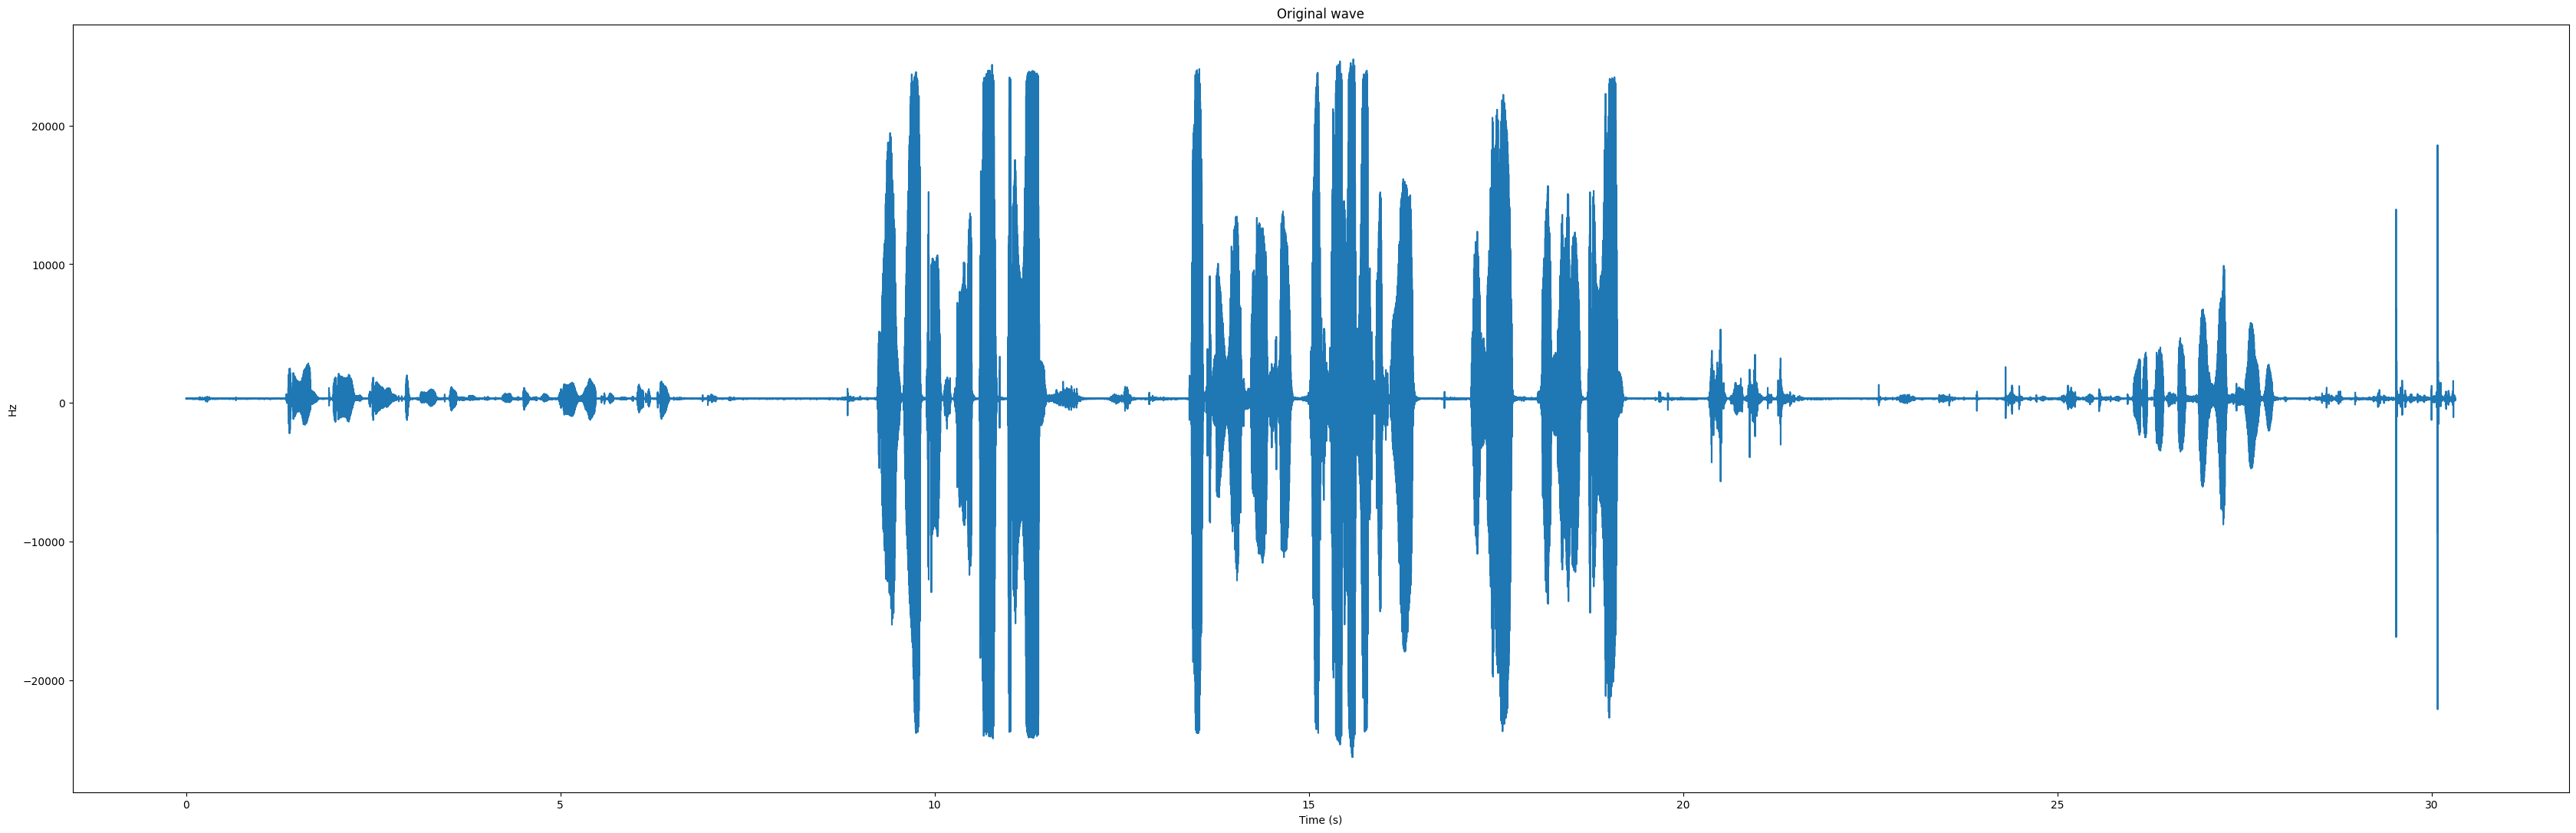

In [189]:
origPlotData = np.frombuffer(origData, np.int16)
origDataLen = len(origPlotData)
time = np.linspace(0, origDataLen / origRate, num = origDataLen)
plt.figure(figsize = FIG_SIZE)
plt.xlabel("Time (s)")
plt.ylabel("Hz")
plt.title("Original wave")
plt.plot(time, origPlotData)
plt.show()

In [196]:
processedData = origPlotData.copy()
processedDataLen = len(processedData)
print(f"len = {processedDataLen}")
STEP = 20
flag = True

agc = AGC(origCh, FILTER_SIZE, origRate, STEP)

for i in range(0, processedDataLen, STEP):
    subStep = i + STEP
    if (subStep >= processedDataLen):
        break

    # TODO: передавать в обработку data[i, subStep]
    agc.filter_frame(processedData[i:subStep])
    
    # for j in range(i, subStep):
    #     # processedData[j] = np.iinfo(np.int16).max if flag else np.iinfo(np.int16).min
    #     processedData[j] += 500

    if flag:
        flag = False
    else:
        flag = True

len = 242560


NameError: name 'deque' is not defined

In [ ]:
plt.figure(figsize = FIG_SIZE)
plt.xlabel("Time (s)")
plt.ylabel("Hz")
plt.title("Processed + orig")
plt.plot(time, origPlotData, color = 'r')
plt.plot(time, processedData, color = 'b')
plt.grid(True)
plt.show()